# Arctic Permafrost Modeling

ATS initially came out of a desire to model Arctic permafrost using the best available understanding of cryosphere processes, including subsurface flow in partially saturated, partially frozen soils.  These simulations form the basis for doing this work, and represent an approach designed for continuous permafrost.

This demo also is useful for seeing how layering works in ATS, as there are heterogeneous properties throughout (peat and mineral soil layers).

The basic spinup of this sequence is as follows:

* spinup0-water_table: Run a steady-state problem to establish a water table
* spinup1-freezeup: Freeze the steady-state water table from below, establishing a saturated ice table.
* spinup2-dynamic: Drive a simulation with an annual, cyclic steady-state meterological data, derived from DayMet but smoothed extensively to generate a climatologically "typical" year.  This establishes a permafrost vs active layer, reasonable saturation state, etc.

After these, many choices are available.  1D column runs could be run using the same input file as spinup2-dynamic and driven with real daily data.  2D or 3D runs on transects, hillslopes, or other geometries can have the result of spinup2-dynamic draped from the surface and lateral flow and spatial variations can be considered.  All of these use the same basic form of input file, with a differing mesh, so we simply demonstrate one, including snow distribution to capture variations in snowpack with topography.

Work to do - 
* Plot also the temperature variables and ice variables in the plot! 
['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'density_rock.cell.0', 'dwater_content|dtemperature.cell.0', 'energy.cell.0', 'enthalpy.cell.0', 'enthalpy_times_relative_permeability.cell.0', 'internal_energy_ice.cell.0', 'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0', 'mass_density_liquid.cell.0', 'molar_density_ice.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_ice.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'thermal_conductivity.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']

In [2]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

ModuleNotFoundError: No module named 'ats_xdmf'

In [2]:
import h5py
import pandas as pd

In [35]:
sns.set()

## spinup1: Freeze steady-state to generate ice column

Transient simulations are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

To establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in spinup0 such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, a bottom pressure is set for spinup0, then frozen from below in spinup1.  If the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a smaller bottom pressure in spinup0.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the spinup0 bottom pressure can be used to quickly find a pressure that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.

NOTE: This run takes some time (especially if the code is built in debug mode), ~10 minutes.

In [3]:
file_name = 'permafrost_column.demo'
input_filename = 'permafrost_column.xml'

In [4]:
# load the ATS solution
directory = f"./{file_name}/"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

### RK - work

### Input data - 

In [ ]:
        ### Extracting the node information of the cells
        # Extracted the the coordinates from paraview - have to think of a smarter way!
        data_nodes = pd.read_csv('data/column_coord.csv')
        
        # Storing the dz coordinates
        ### Finding the average between two rows - to find centroidal distance

        #z_1 = data_nodes['Points_2'][1:]
        data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
        #z_1.append({'0':0},ignore_index=True)
        data_nodes['Points_2_a'][0] = 0
        data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
        
        z = data_nodes['dz'][1:86]
        
        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

        mass_density_all = np.array(hdf.get(f'mass_density_liquid.cell.0/{t}'))
        mass_density = mass_density_all.flatten()
        data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density


In [16]:
len()

3650

In [54]:
with h5py.File(f'data/spinup-10yr.h5','r') as hdf:
    ls = list(hdf.keys())
    #print('List of datasets in this file: \n \n', ls)
    #print('\n')
    air_temperature = np.array(hdf.get('air temperature [K]'))
    #print(air_temperature)
    
    data_input = pd.DataFrame(index=z)
    
    #print(data_input)
    for i in ls:
        #print(i)
        data_input[f'{i}'] = np.array(hdf.get(f'{i}'))
        
data_input['time [days]'] = data_input['time [s]']/86400        
data_input.index = data_input['time [days]']

data_input['Air temperature [°C]'] = data_input['air temperature [K]'] - 273.15
data_input.head()

,air temperature [K],incoming shortwave radiation [W m^-2],precipitation rain [m s^-1],precipitation snow [m SWE s^-1],relative humidity [-],time [s],wind speed [m s^-1],time [days],Air temperature [°C]
time [days],,,,,,,,,
0.0,250.274842,-0.072606,0.0,5.937940e-09,0.835239,0.0,5.809783,0.0,-22.875158
1.0,250.162168,-0.080807,0.0,5.937940e-09,0.834729,86400.0,5.814823,1.0,-22.987832
2.0,250.041937,-0.092183,0.0,5.937940e-09,0.834057,172800.0,5.828910,2.0,-23.108063
3.0,249.890313,-0.103809,0.0,5.937940e-09,0.833188,259200.0,5.855721,3.0,-23.259687
4.0,249.748460,-0.119944,0.0,5.937940e-09,0.832292,345600.0,5.874984,4.0,-23.401540


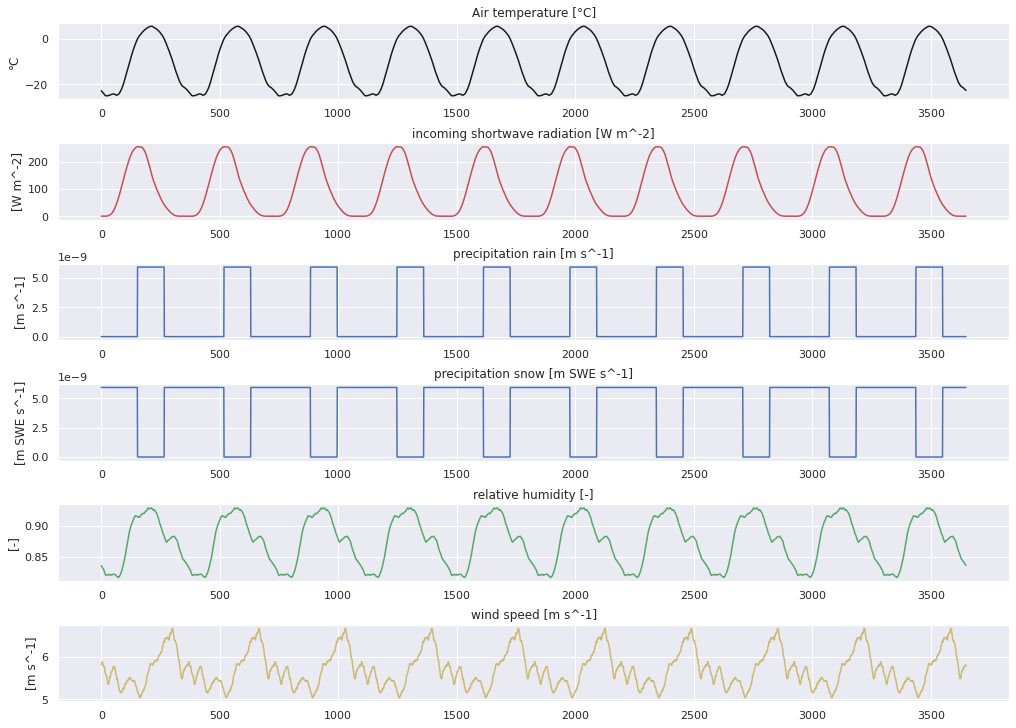

In [56]:
fig2 = plt.figure(figsize=(14,10), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=6, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])
f2_ax5 = fig2.add_subplot(spec2[4, 0])
f2_ax6 = fig2.add_subplot(spec2[5, 0])

f2_ax1.set_title('Air temperature [°C]')
f2_ax1.plot(data_input['Air temperature [°C]'],'k', label='Air temperature [°C]')
f2_ax1.set_ylabel('°C')
#f2_ax1.set_xlabel('Date')
#f2_ax1.legend()
f2_ax1.grid(True)

f2_ax2.set_title('incoming shortwave radiation [W m^-2]')
f2_ax2.plot(data_input['incoming shortwave radiation [W m^-2]'],'r', label='incoming shortwave radiation [W m^-2]')
f2_ax2.set_ylabel('[W m^-2]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax2.grid(True)

f2_ax3.set_title('precipitation rain [m s^-1]')
f2_ax3.plot(data_input['precipitation rain [m s^-1]'],'b', label='precipitation rain [m s^-1]')
f2_ax3.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax3.grid(True)

f2_ax4.set_title('precipitation snow [m SWE s^-1]')
f2_ax4.plot(data_input['precipitation snow [m SWE s^-1]'],'b', label='precipitation snow [m SWE s^-1]')
f2_ax4.set_ylabel('[m SWE s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax4.grid(True)

f2_ax5.set_title('relative humidity [-]')
f2_ax5.plot(data_input['relative humidity [-]'],'g', label='relative humidity [-]')
f2_ax5.set_ylabel('[-]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax5.grid(True)

f2_ax6.set_title('wind speed [m s^-1]')
f2_ax6.plot(data_input['wind speed [m s^-1]'],'y', label='wind speed [m s^-1]')
f2_ax6.set_ylabel('[m s^-1]')
#f2_ax2.set_xlabel('Date')
#f2_ax2.legend()
f2_ax6.grid(True)

In [57]:
### Extracting the node information of the cells
# Extracted the the coordinates from paraview - have to think of a smarter way!

data_nodes = pd.read_csv('data/column_coord.csv')
data_nodes
# Points_2 - represents the dz 

,Points_0,Points_1,Points_2,Points_Magnitude,Point ID
0,0,0,5.00,5.0000,0
1,0,0,4.98,4.9800,1
2,0,0,4.96,4.9600,2
3,0,0,4.94,4.9400,3
4,0,0,4.92,4.9200,4
...,...,...,...,...,...
339,1,1,-27.00,27.0370,339
340,1,1,-29.00,29.0345,340
341,1,1,-31.00,31.0322,341
342,1,1,-33.00,33.0303,342


In [58]:
### Finding the average between two rows - to find centroidal distance

#z_1 = data_nodes['Points_2'][1:]
data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
#z_1.append({'0':0},ignore_index=True)
data_nodes['Points_2_a'][0] = 0
data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
data_nodes

<ipython-input-58-7ed70db12958>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nodes['Points_2_a'][0] = 0


,Points_0,Points_1,Points_2,Points_Magnitude,Point ID,Points_2_a,dz
0,0,0,5.00,5.0000,0,0.00,2.50
1,0,0,4.98,4.9800,1,5.00,4.99
2,0,0,4.96,4.9600,2,4.98,4.97
3,0,0,4.94,4.9400,3,4.96,4.95
4,0,0,4.92,4.9200,4,4.94,4.93
...,...,...,...,...,...,...,...
339,1,1,-27.00,27.0370,339,-25.00,-26.00
340,1,1,-29.00,29.0345,340,-27.00,-28.00
341,1,1,-31.00,31.0322,341,-29.00,-30.00
342,1,1,-33.00,33.0303,342,-31.00,-32.00


In [59]:
# Storing the dz coordinate
dz = data_nodes['Points_2'][:86]
dz

0      5.00
1      4.98
2      4.96
3      4.94
4      4.92
      ...  
81   -27.00
82   -29.00
83   -31.00
84   -33.00
85   -35.00
Name: Points_2, Length: 86, dtype: float64

### Output data:

#### The data files are stored in three seperate files:
1. Subsurface data - ats_vis_data.h5
2. Surface data - ats_vis_surface_data.h5
3. Snow data - ats_vis_snow_data.h5

In [ ]:
file_name = 'permafrost_column.demo'
input_filename = 'permafrost_column.xml'

In [79]:
def inputfiles_pddataframes(file_name,t):
    """
    The function is defined to read the input files from the ats simulation. 
    For each time instance, a dataframe can store the data.
 
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    t : The time instance at which the data is required.
    Ex: cell_volume.cell.0/{t} - here 0/0 - signifies the first directory (with data at t=0), 
    similary 0/1 - signifies the second directory (with data at t=1).
            
    Output parameters:
    
    data_results : pandas dataframe with all the key elements of the simulation.
    
    - idea - can't we write a smart function that directly accesses all the columns? - !
    
    """
    
    with h5py.File(file_name,'r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{t}'))
        cell_volume = cell_volume_all.flatten()
        
        ### Extracting the node information of the cells
        # Extracted the the coordinates from paraview - have to think of a smarter way!
        data_nodes = pd.read_csv('data/column_coord.csv')
        
        # Storing the dz coordinates
        ### Finding the average between two rows - to find centroidal distance

        #z_1 = data_nodes['Points_2'][1:]
        data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
        #z_1.append({'0':0},ignore_index=True)
        data_nodes['Points_2_a'][0] = 0
        data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
        
        z = data_nodes['dz'][1:86]
        
        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])
        
        ls = list(hdf.keys())
        for i in ls:
            data_results[f'{i}'] = np.array(hdf.get(f'{i}/{t}'))
        
        return data_results

with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    # Cell_volume
    cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{0}'))
    cell_volume = cell_volume_all.flatten()
        
    ### Extracting the node information of the cells
    # Extracted the the coordinates from paraview - have to think of a smarter way!
    data_nodes = pd.read_csv('data/column_coord.csv')
        
    # Storing the dz coordinates
    ### Finding the average between two rows - to find centroidal distance

    #z_1 = data_nodes['Points_2'][1:]
    data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
    #z_1.append({'0':0},ignore_index=True)
    data_nodes['Points_2_a'][0] = 0
    data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
        
    z = data_nodes['dz'][1:86]
        
    # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
    # Can we simplify the code?
        
    data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])
        


### Storing the data for all time instances

In [81]:
for i in time_period:
    # https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops
    locals()["data_results_"+str(i)] = inputfiles_pddataframes(file_name=f'{file_name}/ats_vis_data.h5', t=i)

<ipython-input-79-a99a4cf9d7ea>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nodes['Points_2_a'][0] = 0


In [82]:
data_results_0.columns

Index(['cell_volume', 'base_porosity.cell.0',
       'capillary_pressure_gas_liq.cell.0',
       'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0',
       'darcy_velocity.cell.0', 'darcy_velocity.cell.1',
       'darcy_velocity.cell.2', 'density_rock.cell.0',
       'dwater_content|dtemperature.cell.0', 'energy.cell.0',
       'enthalpy.cell.0', 'internal_energy_ice.cell.0',
       'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0',
       'mass_density_liquid.cell.0', 'molar_density_ice.cell.0',
       'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0',
       'pressure.cell.0', 'relative_permeability.cell.0',
       'saturation_gas.cell.0', 'saturation_ice.cell.0',
       'saturation_liquid.cell.0', 'temperature.cell.0',
       'thermal_conductivity.cell.0', 'total_energy_source.cell.0',
       'viscosity_liquid.cell.0', 'water_content.cell.0',
       'water_source.cell.0'],
      dtype='object')

In [83]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        print(time_period)

[  0  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 168 170 172 174 176 178
 180 183 204 215 227 231 237 242 245 250 254 257 262 265 268 270 272 276
 279 282 284 288 291 293 295 297 299 301 303 305 307 309 311 313 315 318
 321 323 325 327 329 332 335 337 339 341 344 347 349 351 353 355 357 359
 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 39

In [84]:
len(time_period)

366

In [85]:
time_period[1:]

array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168,
       170, 172, 174, 176, 178, 180, 183, 204, 215, 227, 231, 237, 242,
       245, 250, 254, 257, 262, 265, 268, 270, 272, 276, 279, 28

In [87]:
data_results_663

,cell_volume,base_porosity.cell.0,capillary_pressure_gas_liq.cell.0,capillary_pressure_liq_ice.cell.0,cell_volume.cell.0,darcy_velocity.cell.0,darcy_velocity.cell.1,darcy_velocity.cell.2,density_rock.cell.0,dwater_content|dtemperature.cell.0,...,relative_permeability.cell.0,saturation_gas.cell.0,saturation_ice.cell.0,saturation_liquid.cell.0,temperature.cell.0,thermal_conductivity.cell.0,total_energy_source.cell.0,viscosity_liquid.cell.0,water_content.cell.0,water_source.cell.0
dz,,,,,,,,,,,,,,,,,,,,,
4.99,0.02,0.85,2.250374e+06,5.298638e+07,0.02,0.0,0.0,3.151127e-15,700.0,-2.382990,...,7.457097e-15,0.541897,0.390209,0.067894,253.291499,0.000001,0.0,0.004039,402.245994,0.0
4.97,0.02,0.85,3.994596e+04,5.267982e+07,0.02,0.0,0.0,3.793050e-15,700.0,-0.614002,...,7.631638e-15,0.129425,0.802641,0.067934,253.407973,0.000002,0.0,0.004015,760.156252,0.0
4.95,0.02,0.85,5.707659e+04,5.244080e+07,0.02,0.0,0.0,-7.590337e-17,700.0,-0.724062,...,7.771014e-15,0.153839,0.778195,0.067966,253.498768,0.000002,0.0,0.003997,738.968559,0.0
4.93,0.02,0.85,8.296519e+04,5.219526e+07,0.02,0.0,0.0,-1.076992e-16,700.0,-0.852639,...,7.917264e-15,0.182130,0.749871,0.067999,253.592016,0.000002,0.0,0.003979,714.417595,0.0
4.91,0.02,0.85,1.171949e+05,5.194214e+07,0.02,0.0,0.0,-1.811086e-16,700.0,-0.984631,...,8.071386e-15,0.210779,0.721188,0.068033,253.688128,0.000002,0.0,0.003960,689.556976,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-26.00,2.00,0.50,-9.746447e+05,2.415015e+07,2.00,0.0,0.0,1.151917e-16,2170.0,3.686638,...,1.652996e-10,0.000000,0.777798,0.222202,264.149293,0.000002,0.0,0.002486,52973.973782,0.0
-28.00,2.00,0.50,-1.041343e+06,2.414976e+07,2.00,0.0,0.0,1.726871e-16,2170.0,3.693956,...,1.653174e-10,0.000000,0.777798,0.222202,264.149741,0.000002,0.0,0.002486,53043.977773,0.0
-30.00,2.00,0.50,-1.129699e+06,2.415037e+07,2.00,0.0,0.0,2.543496e-16,2170.0,3.703318,...,1.653114e-10,0.000000,0.777798,0.222202,264.149910,0.000002,0.0,0.002486,53136.713753,0.0


### Defining a dataframe that extracts the data for a single variable for all time instances

In [88]:
def input_datavar(file_name, variable):
    """
    The function defined to extract a variable across all time instances.
    
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    variable: Name of the variable in the dataset that you are interested in.
    Ex: 'cell_volume'
    
    Output parameters:
    
    data_var : pandas dataframe with the time series data of the variable.
    
    """
    
    # Storing the dz coordinates
    ### Finding the average between two rows - to find centroidal distance

    #z_1 = data_nodes['Points_2'][1:]
    data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
    #z_1.append({'0':0},ignore_index=True)
    data_nodes['Points_2_a'][0] = 0
    data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
        
    z = data_nodes['dz'][1:86]
    
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        data_var = pd.DataFrame(index=z,data=var_0,columns=[f'0'])
        
        for i in time_period[1:]:
            var_all = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var = var_all.flatten()
            
            data_var[f'{i}'] = var
    
    return data_var

In [90]:
### Accessing the variable at all time instances

### Add or remove variable name if required
variables = ['saturation_liquid','saturation_ice','saturation_gas','pressure','relative_permeability','temperature']

for i in variables:
    locals()["df_"+str(i)] = input_datavar(file_name, i)
    len_rows = len(locals()["df_"+str(i)].columns)
    locals()["df_"+str(i)].columns = np.arange(0,len_rows,1)

<ipython-input-88-3a64ce11441b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nodes['Points_2_a'][0] = 0


In [91]:
df_pressure.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
dz,,,,,,,,,,,,,,,,,,,,,
4.99,-23275.828212,-24209.872520,-25259.305592,-26450.167126,-27700.539418,-28941.531450,-30169.181643,-31367.996543,-32518.785989,-33624.336798,...,-2.114233e+06,-2.118836e+06,-2.123087e+06,-2.126941e+06,-2.130263e+06,-2.133254e+06,-2.136594e+06,-2.140619e+06,-2.144956e+06,-2.149049e+06
4.97,-21156.715048,-22012.605859,-22996.144744,-24125.058631,-25318.686066,-26510.386734,-27693.292484,-28851.874633,-29967.323319,-31041.022275,...,6.170352e+04,6.166098e+04,6.162123e+04,6.158504e+04,6.155360e+04,6.152526e+04,6.149409e+04,6.145700e+04,6.141702e+04,6.137904e+04
4.95,-17573.929189,-18345.477449,-19253.672812,-20307.493794,-21429.592277,-22556.558789,-23679.129680,-24781.952147,-25846.857736,-26873.958652,...,4.474323e+04,4.467888e+04,4.461822e+04,4.456279e+04,4.451433e+04,4.447058e+04,4.442298e+04,4.436682e+04,4.430626e+04,4.424841e+04
4.93,-12643.071050,-13327.221693,-14153.317116,-15121.883015,-16160.538129,-17209.945840,-18259.019554,-19292.799213,-20293.995332,-21261.621209,...,1.912907e+04,1.902982e+04,1.893551e+04,1.884896e+04,1.877285e+04,1.870400e+04,1.862987e+04,1.854314e+04,1.844962e+04,1.835981e+04
4.91,-6278.889542,-6873.950780,-7611.996307,-8486.014759,-9429.983777,-10389.454278,-11352.145709,-12303.740684,-13228.077232,-14123.275728,...,-1.471379e+04,-1.486180e+04,-1.500352e+04,-1.513410e+04,-1.524963e+04,-1.535435e+04,-1.546602e+04,-1.559554e+04,-1.573515e+04,-1.586989e+04


In [92]:
pressure_head_data = df_pressure/(10000)

In [93]:
pressure_head_data

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
dz,,,,,,,,,,,,,,,,,,,,,
4.99,-2.327583,-2.420987,-2.525931,-2.645017,-2.770054,-2.894153,-3.016918,-3.136800,-3.251879,-3.362434,...,-211.423265,-211.883606,-212.308710,-212.694107,-213.026339,-213.325378,-213.659449,-214.061910,-214.495614,-214.904851
4.97,-2.115672,-2.201261,-2.299614,-2.412506,-2.531869,-2.651039,-2.769329,-2.885187,-2.996732,-3.104102,...,6.170352,6.166098,6.162123,6.158504,6.155360,6.152526,6.149409,6.145700,6.141702,6.137904
4.95,-1.757393,-1.834548,-1.925367,-2.030749,-2.142959,-2.255656,-2.367913,-2.478195,-2.584686,-2.687396,...,4.474323,4.467888,4.461822,4.456279,4.451433,4.447058,4.442298,4.436682,4.430626,4.424841
4.93,-1.264307,-1.332722,-1.415332,-1.512188,-1.616054,-1.720995,-1.825902,-1.929280,-2.029400,-2.126162,...,1.912907,1.902982,1.893551,1.884896,1.877285,1.870400,1.862987,1.854314,1.844962,1.835981
4.91,-0.627889,-0.687395,-0.761200,-0.848601,-0.942998,-1.038945,-1.135215,-1.230374,-1.322808,-1.412328,...,-1.471379,-1.486180,-1.500352,-1.513410,-1.524963,-1.535435,-1.546602,-1.559554,-1.573515,-1.586989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-26.00,107.596711,107.596711,107.596711,107.596711,107.596711,107.596711,107.596711,107.596711,107.596711,107.596711,...,107.596927,107.596931,107.596936,107.596940,107.596945,107.596950,107.596954,107.596959,107.596964,107.596969
-28.00,114.266708,114.266708,114.266708,114.266708,114.266708,114.266708,114.266708,114.266708,114.266708,114.266708,...,114.266793,114.266795,114.266797,114.266799,114.266801,114.266803,114.266805,114.266807,114.266809,114.266811
-30.00,123.102348,123.102348,123.102348,123.102349,123.102349,123.102349,123.102349,123.102349,123.102349,123.102349,...,123.102390,123.102391,123.102392,123.102392,123.102393,123.102394,123.102395,123.102395,123.102396,123.102397


Text(0.5, 0, 'Saturation (-)')

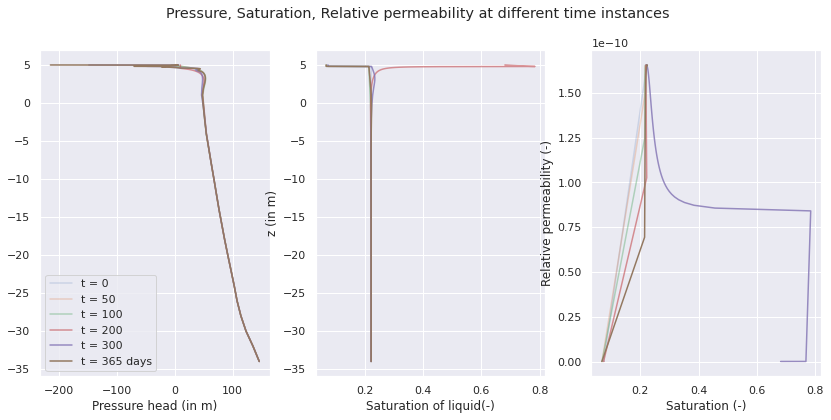

In [97]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[50], z, alpha=0.3)
ax1.plot(df_saturation_liquid[100], z, alpha=0.5)
ax1.plot(df_saturation_liquid[200], z, alpha=0.6)
ax1.plot(df_saturation_liquid[300], z, alpha=0.8)
ax1.plot(df_saturation_liquid[365], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[50], z, alpha=0.3, label ='t = 50')
ax2.plot(pressure_head_data[100], z, alpha=0.4, label ='t = 100')
ax2.plot(pressure_head_data[200], z, alpha=0.6, label ='t = 200')
ax2.plot(pressure_head_data[300], z, alpha=0.8, label ='t = 300')
ax2.plot(pressure_head_data[365], z, alpha=1, label ='t = 365 days')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2)
ax3.plot(df_saturation_liquid[50], df_relative_permeability[2], alpha=0.3)
ax3.plot(df_saturation_liquid[100], df_relative_permeability[4], alpha=0.4)
ax3.plot(df_saturation_liquid[150], df_relative_permeability[6], alpha=0.6)
ax3.plot(df_saturation_liquid[200], df_relative_permeability[8], alpha=0.8)
ax3.plot(df_saturation_liquid[365], df_relative_permeability[10], alpha=1)
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
#ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')


Text(0.5, 0, 'Saturation (-)')

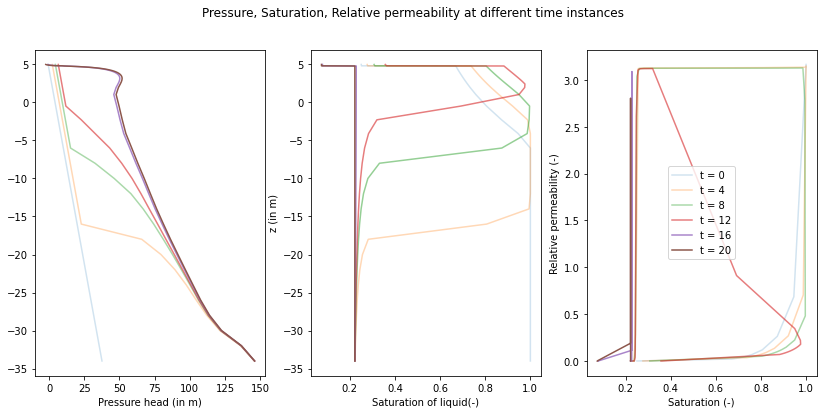

In [35]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2)
ax2.plot(pressure_head_data[4], z, alpha=0.3)
ax2.plot(pressure_head_data[8], z, alpha=0.4)
ax2.plot(pressure_head_data[12], z, alpha=0.6)
ax2.plot(pressure_head_data[16], z, alpha=0.8)
ax2.plot(pressure_head_data[19], z, alpha=1)
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
#ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2, label ='t = 0')
ax3.plot(df_saturation_liquid[4], df_relative_permeability[2], alpha=0.3, label ='t = 4')
ax3.plot(df_saturation_liquid[8], df_relative_permeability[4], alpha=0.4, label ='t = 8')
ax3.plot(df_saturation_liquid[12], df_relative_permeability[6], alpha=0.6, label ='t = 12')
ax3.plot(df_saturation_liquid[16], df_relative_permeability[8], alpha=0.8, label ='t = 16')
ax3.plot(df_saturation_liquid[19], df_relative_permeability[10], alpha=1, label ='t = 20')
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')

Text(0.5, 0, 'Temperature (K)')

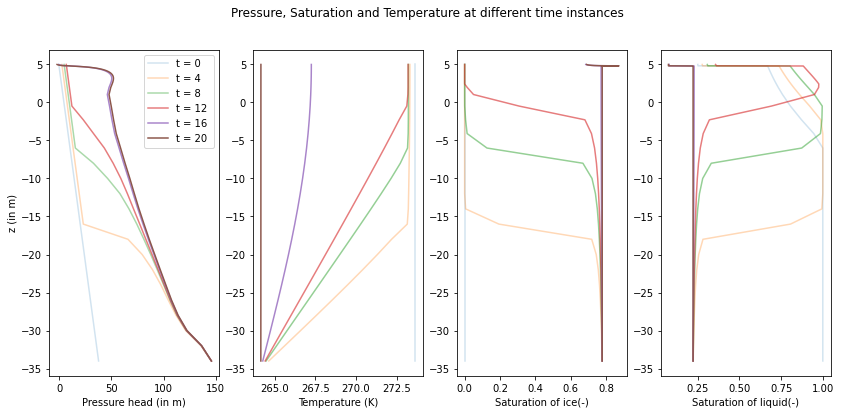

In [36]:
fig, (ax2, ax4, ax3,ax1) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation and Temperature at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 ')
ax2.plot(pressure_head_data[19], z, alpha=1, label ='t = 20 ')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.legend()

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[16], z, alpha=0.8)
ax3.plot(df_saturation_ice[19], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_xlabel('Saturation of ice(-)')

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[16], z, alpha=0.8)
ax4.plot(df_temperature[19], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_xlabel('Temperature (K)')

* Q - Why does pressure increase to a large extent when liquid freezes to ice? - Density of ice and water are 0.9167–0.9168 g/cm3 and  0.9998–0.999863 g/cm3 - Change in temperature 
* https://courses.lumenlearning.com/cheminter/chapter/phase-diagram-for-water/ - Read this link!

Text(0.5, 0, 'Temperature (K)')

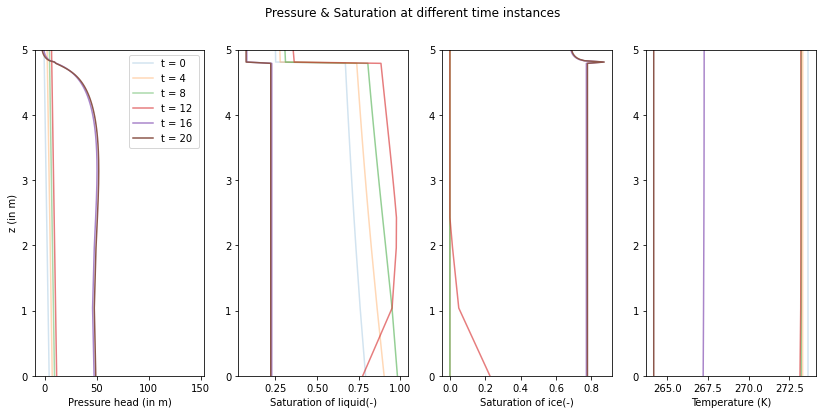

In [108]:
fig, (ax2, ax1, ax3,ax4) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure & Saturation at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[19], z, alpha=1)
ax1.set_ylim(0,5)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 ')
ax2.plot(pressure_head_data[19], z, alpha=1, label ='t = 20 ')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.set_ylim(0,5)
ax2.legend()

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[16], z, alpha=0.8)
ax3.plot(df_saturation_ice[19], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_ylim(0,5)
ax3.set_xlabel('Saturation of ice(-)')

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[16], z, alpha=0.8)
ax4.plot(df_temperature[19], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_ylim(0,5)
ax4.set_xlabel('Temperature (K)')

In [ ]:
### Plot along with material properties! - Plot Relative permeability